In [32]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [33]:
import george
from george.kernels import MyDijetKernelSimp, SignalKernel

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import corner

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

### load inputs

In [34]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#hyperparameters (kernel and mean) from GP fit to ATLAS data.






### Gaussian signal function

In [35]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### Calculate z values and chi squared 

In [36]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### mean and variance of non-central chi2

In [37]:
def chi2_mean_variance(DOF, nc):
    mean = nc
    variance = np.sqrt(nc)
    return mean, variance

### Poisson log likelihood

In [38]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

### remove zero count bins to use for GP fits

In [39]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [40]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

### pretty plots showing background only fit and background+signal fit

In [41]:
def makePrettyPlots_signal(xs, ys, bkgs, bkgsigs, title, mass, col = 'g', ymax = 2e5):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data+Injected signal")
    bkg1Plot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="Background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Signal-plus-background")
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=30)
    ax1.axvline(mass, color='black', lw=1, linestyle="--")
    #ax1.arrow(mass, 1.5e2, 0, 3e2, lw=5, head_width=50, head_length=125)
    
    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.axvline(mass, color='black', lw=1, linestyle="--")
    #ax2.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)

    zvals_2, chi2_2 = calcSignificance(ys, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)
    #ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.axvline(mass, color='black', lw=1, linestyle="--")
    #ax3.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)
    

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### plot distribution of log likelihood from fits to toys

In [49]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GP_LLH), min(FF_LLH))
    highx = max(max(GP_LLH), max(FF_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    ax1.set_ylim([])
    ax1.set_xlim([0, hgh])
    bf_params_1 = 0
    if drawchi2:
        bf_params_1, bf_cov_1 = op.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", bf_params_1
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_1[0]) #bf_params[1]*
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    ax2.set_xlim([0, highx])
    bf_params_2 = 0
    if drawchi2:
        bf_params_2, bf_cov_2 = op.curve_fit(ncchi, bin_centers, hFF)
        print "nc ", bf_params_2
        nc_chi = sum(hFF)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_2[0]) #bf_params[1]*
        ax2.plot(bin_centers, nc_chi, c='r', linewidth=3)

    plt.show()
    return bf_params_1, bf_params_2



### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [43]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  
        


### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [44]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

(300, 3500, 250)
0
background only time: 0.00314807891846
background + signal time: 0.00340604782104
chi2 bkg+signal mu=0 376.337318907
chi2 bkg+signal 292.050910319


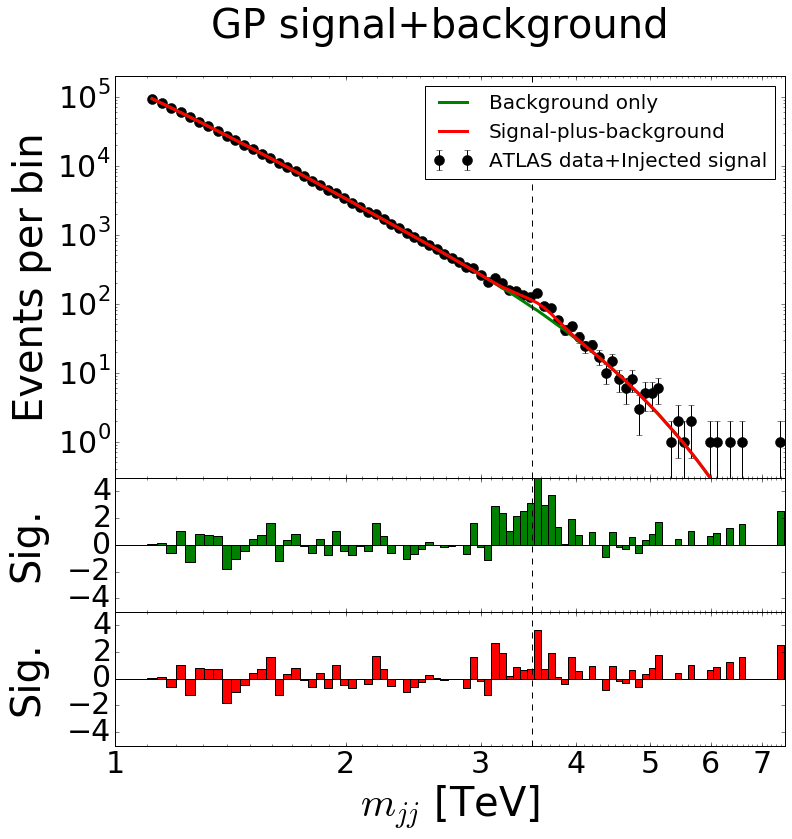

500
background only time: 0.00294899940491
background + signal time: 0.00346803665161
chi2 bkg+signal mu=0 974.31056734
chi2 bkg+signal 932.094475471


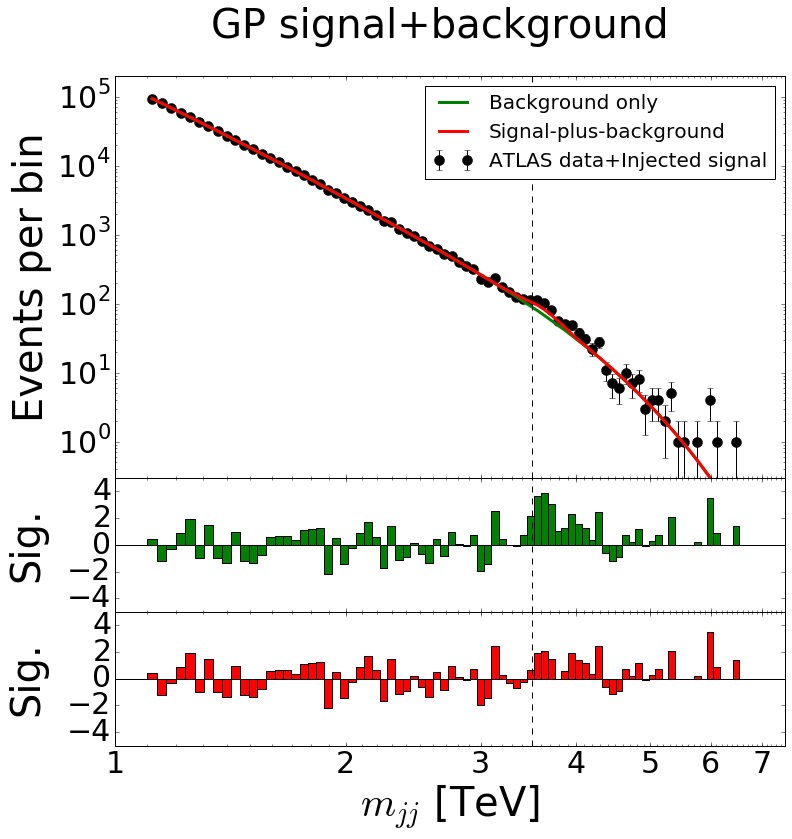

1000
background only time: 0.00296497344971
background + signal time: 0.00347518920898
chi2 bkg+signal mu=0 284.788800421
chi2 bkg+signal 218.813746306


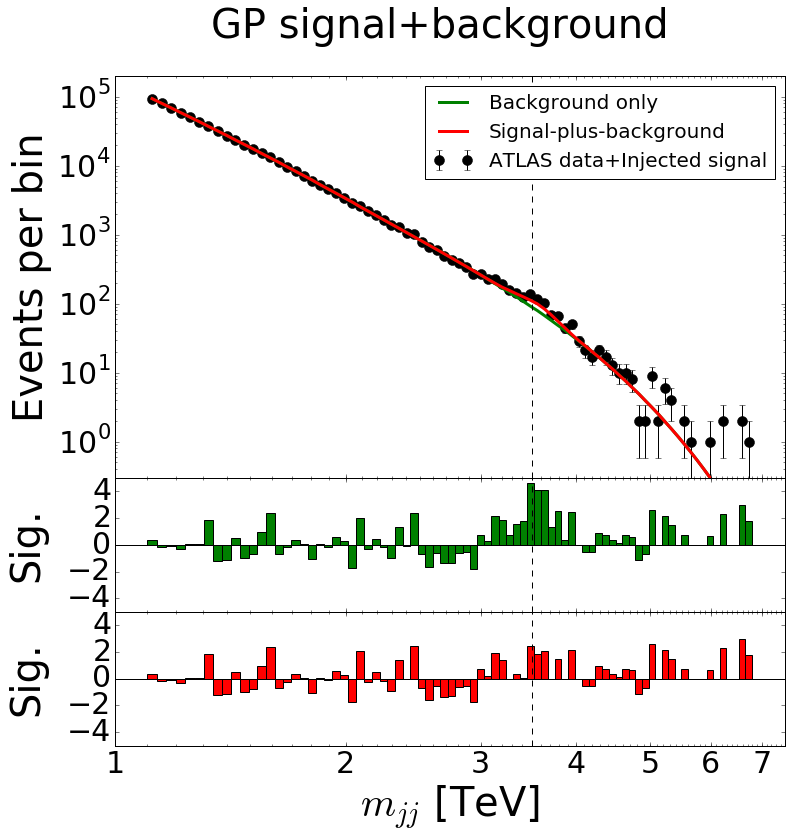

1500
background only time: 0.00469589233398
background + signal time: 0.00497198104858
chi2 bkg+signal mu=0 227.455349328
chi2 bkg+signal 178.904400758


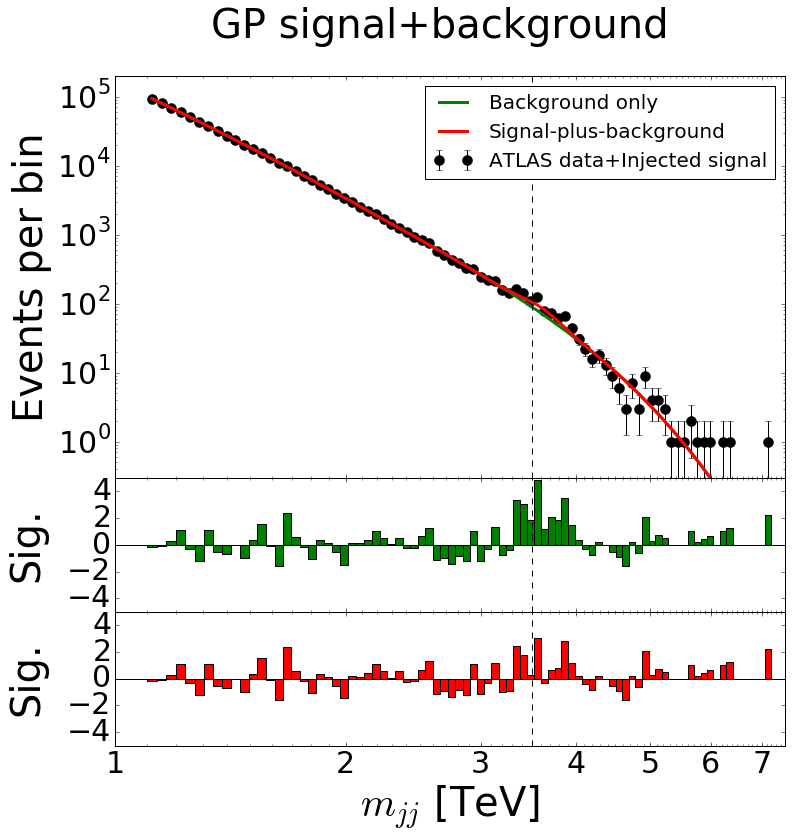

2000
background only time: 0.00303316116333
background + signal time: 0.00357699394226
chi2 bkg+signal mu=0 205.981121016
chi2 bkg+signal 157.725546532


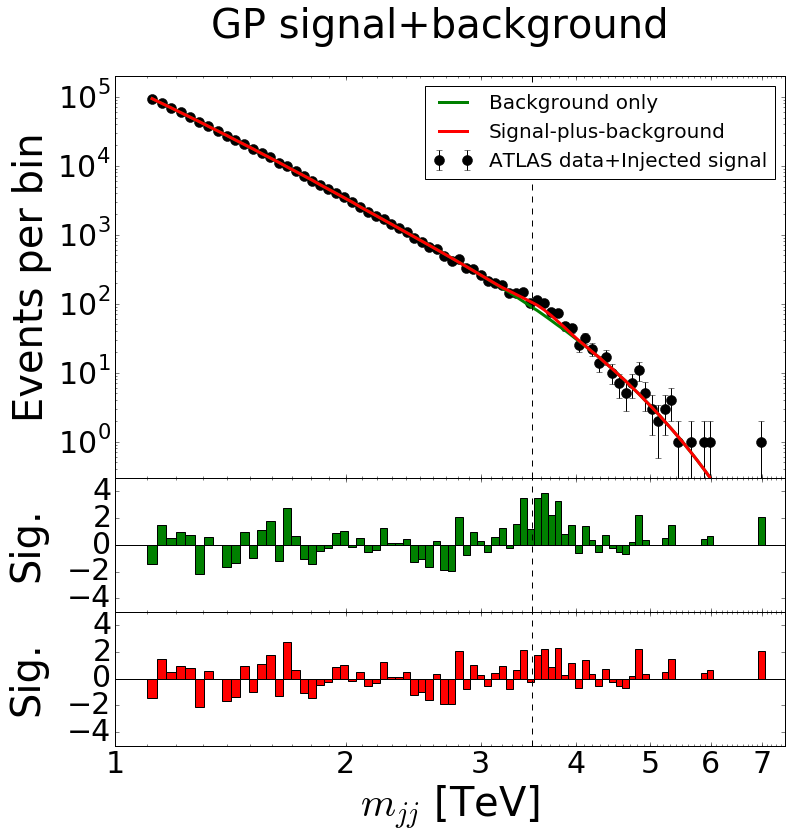

2500
background only time: 0.00283598899841
background + signal time: 0.00341796875
chi2 bkg+signal mu=0 148.510121059
chi2 bkg+signal 108.64319011


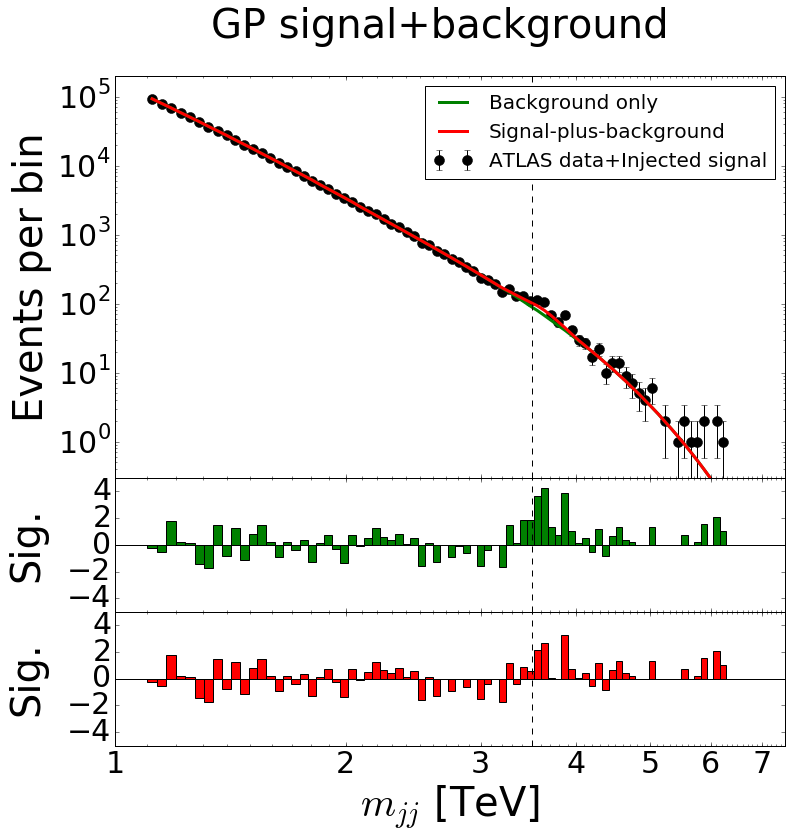

3000
background only time: 0.00329399108887
background + signal time: 0.00344800949097
chi2 bkg+signal mu=0 183.89988983
chi2 bkg+signal 139.065289344


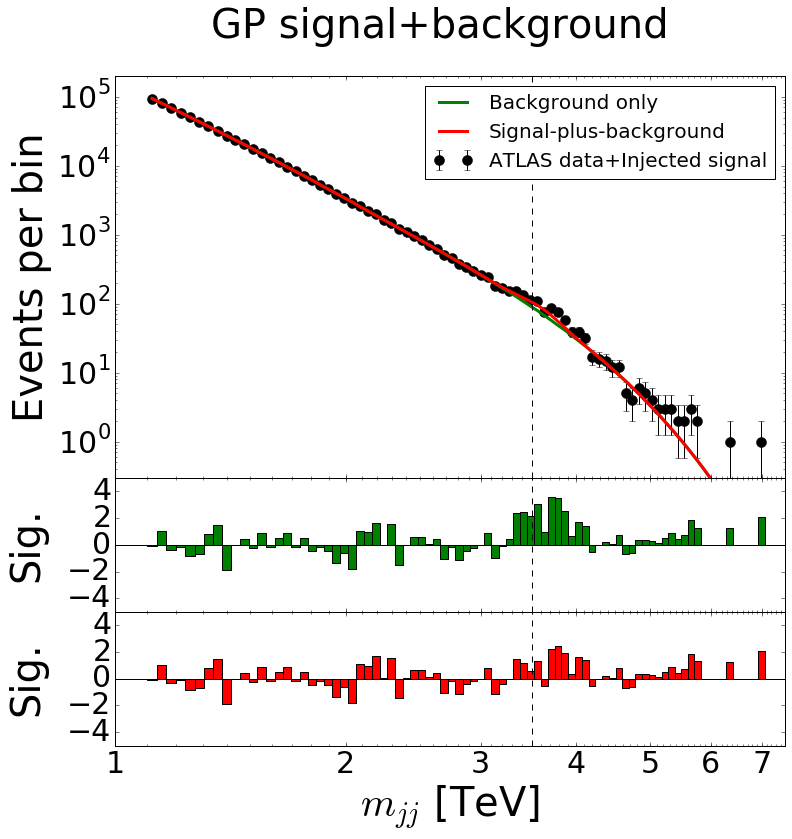

3500
background only time: 0.00350999832153
background + signal time: 0.00434899330139
chi2 bkg+signal mu=0 222.428483129
chi2 bkg+signal 180.205691088


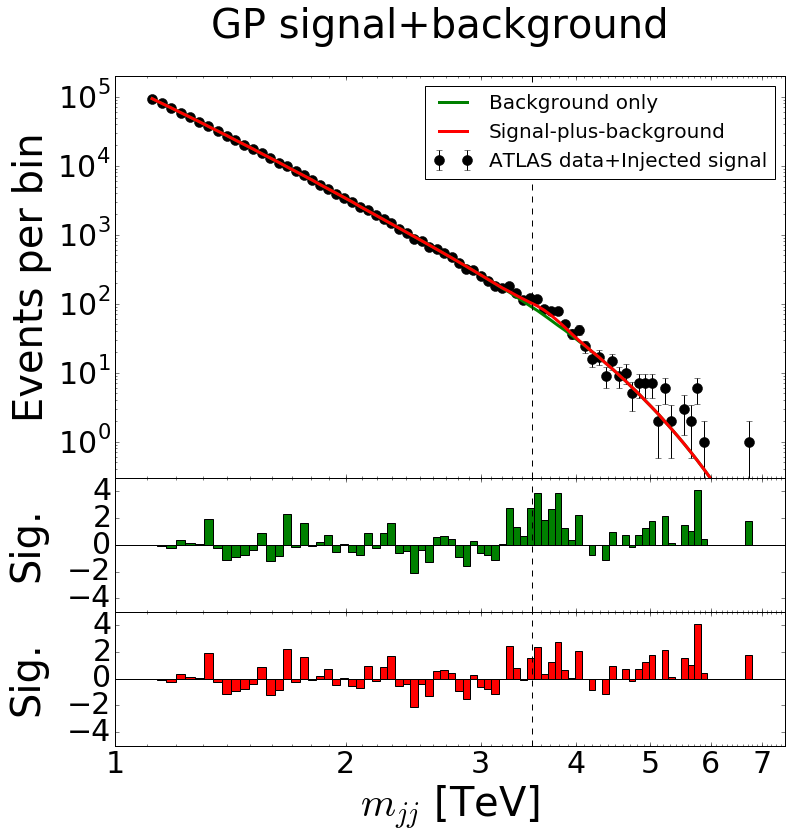

4000
background only time: 0.00439500808716
background + signal time: 0.00468301773071
chi2 bkg+signal mu=0 180.034421072
chi2 bkg+signal 130.873290392


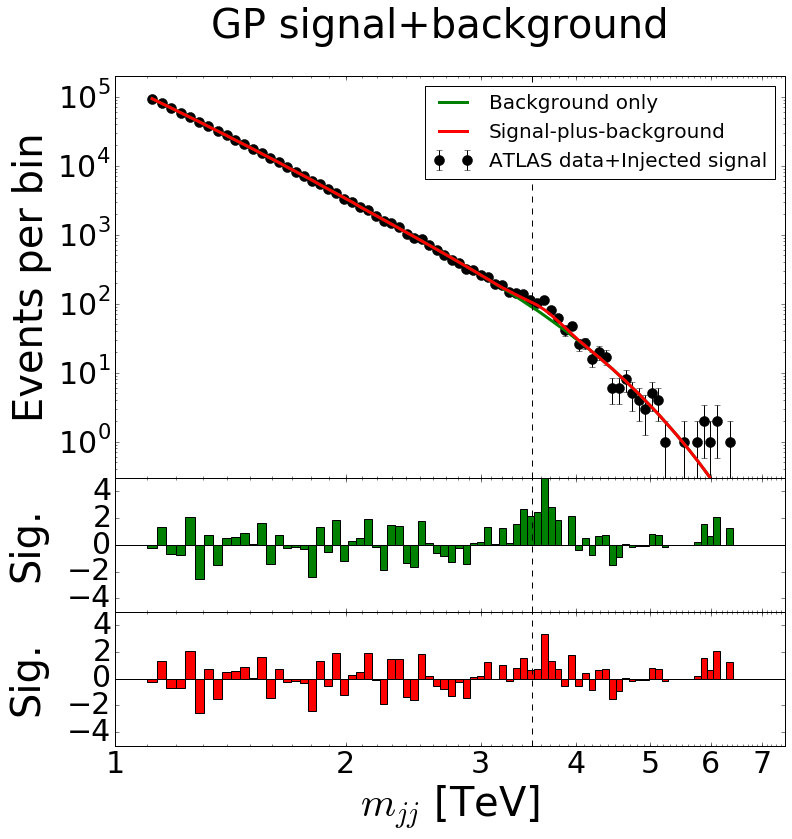

4500
background only time: 0.00306296348572
background + signal time: 0.00391602516174
chi2 bkg+signal mu=0 257.768849797
chi2 bkg+signal 198.129715125


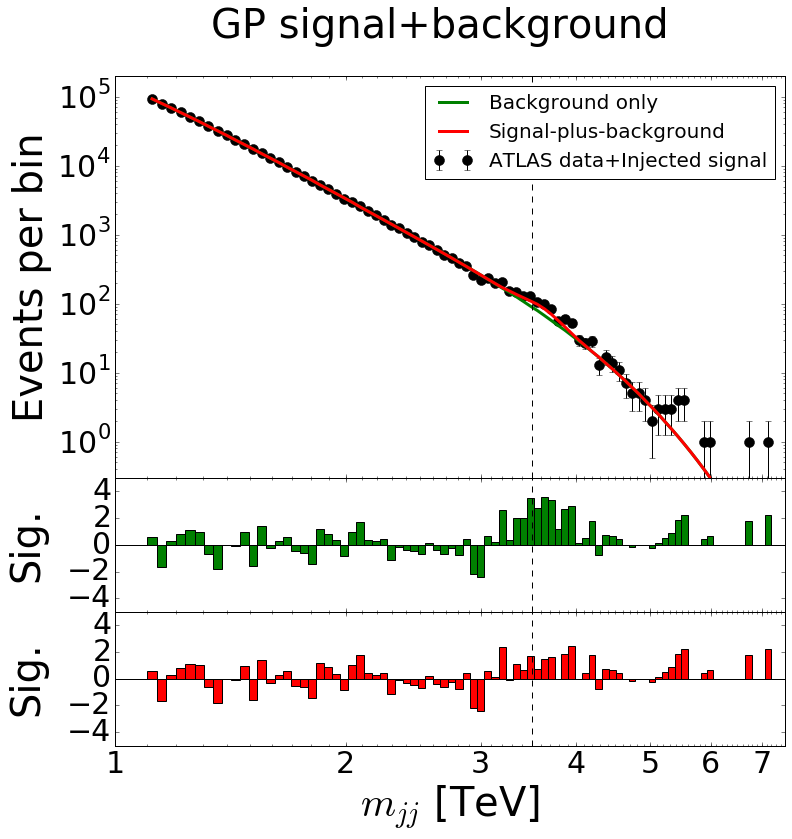

5000
background only time: 0.00361514091492
background + signal time: 0.00387501716614
chi2 bkg+signal mu=0 202.632214082
chi2 bkg+signal 153.975572307


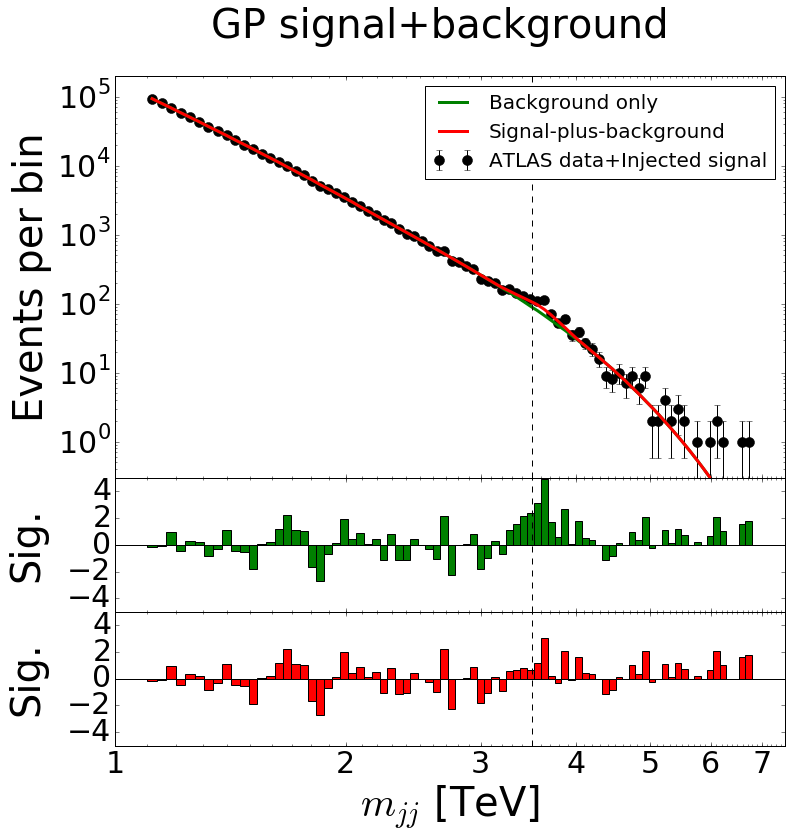

5500
background only time: 0.00293397903442
background + signal time: 0.00347709655762
chi2 bkg+signal mu=0 320.034901783
chi2 bkg+signal 259.791545646


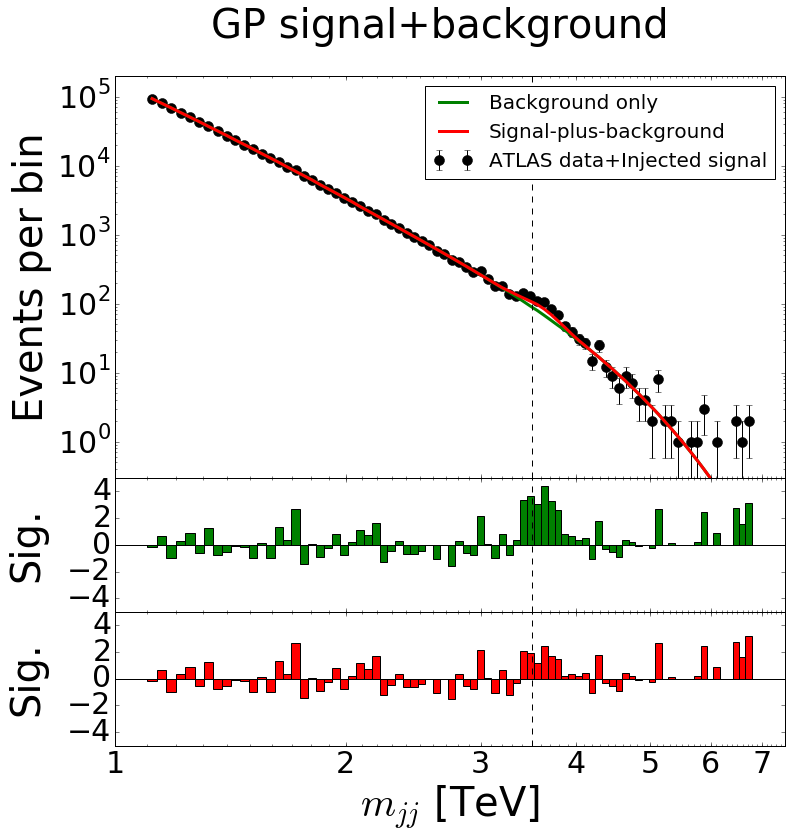

6000
background only time: 0.00323987007141
background + signal time: 0.00370907783508
chi2 bkg+signal mu=0 513.400950982
chi2 bkg+signal 457.27067313


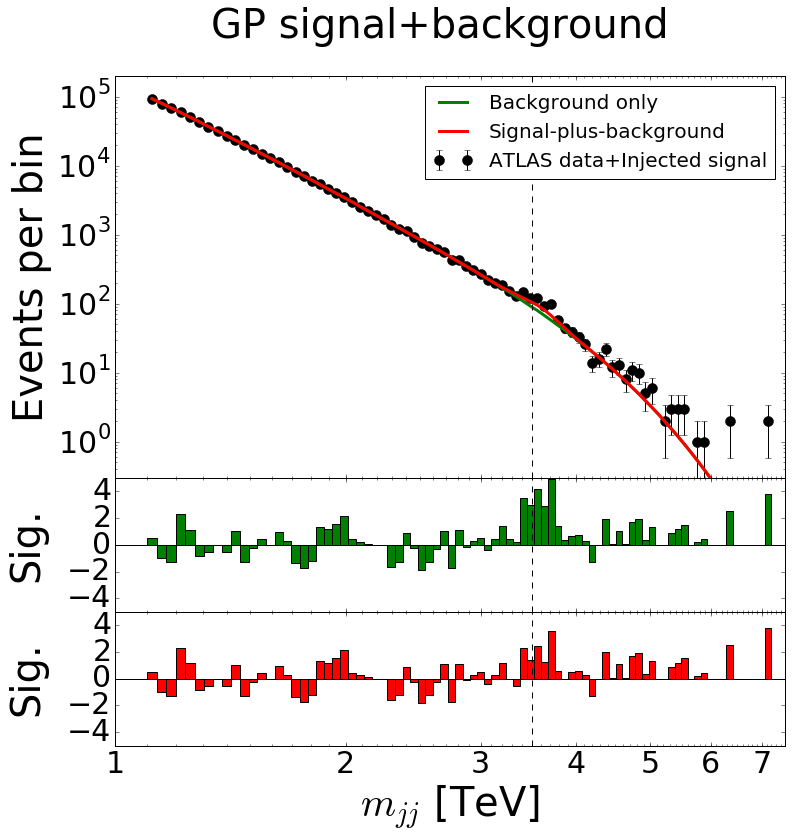

6500
background only time: 0.00283288955688
background + signal time: 0.00344109535217
chi2 bkg+signal mu=0 239.415588997
chi2 bkg+signal 187.483749585


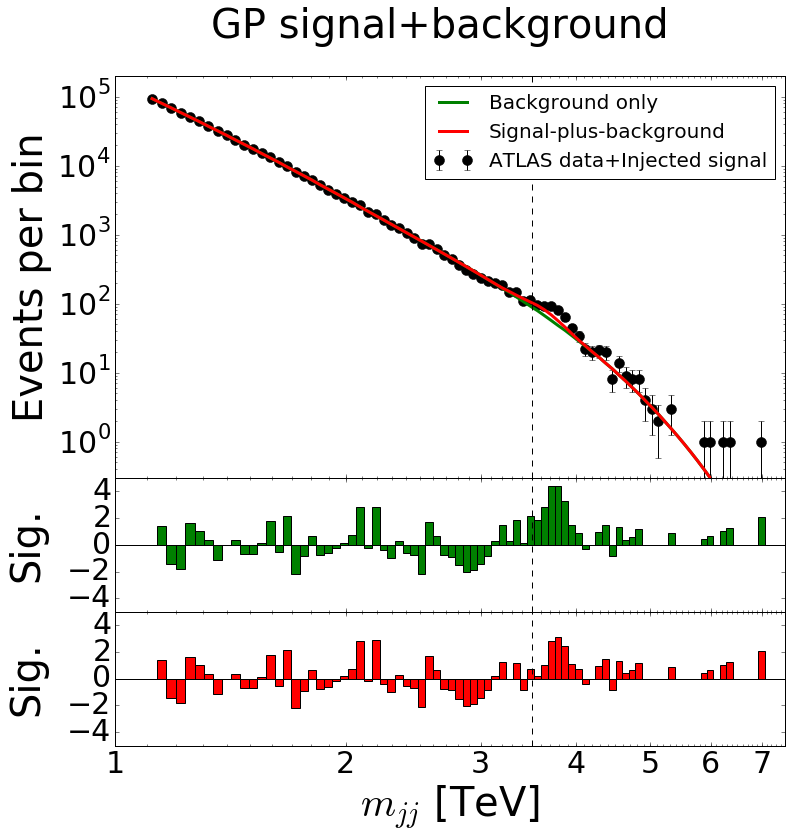

7000
background only time: 0.00291585922241
background + signal time: 0.00341510772705
chi2 bkg+signal mu=0 125.619770342
chi2 bkg+signal 86.9225756268


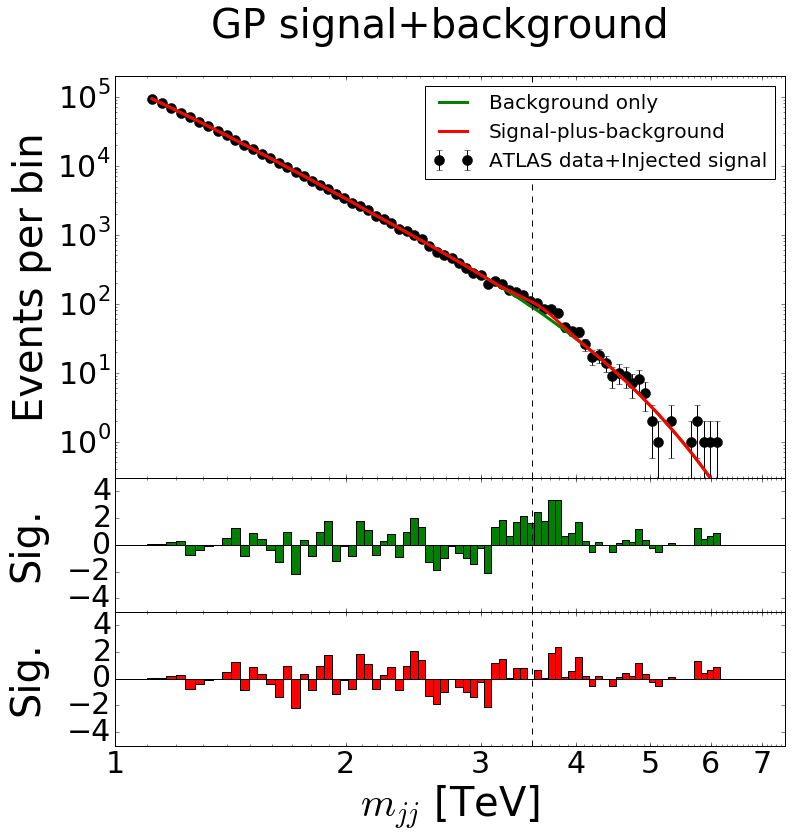

7500
background only time: 0.00302910804749
background + signal time: 0.00351691246033
chi2 bkg+signal mu=0 176.618580389
chi2 bkg+signal 140.614743297


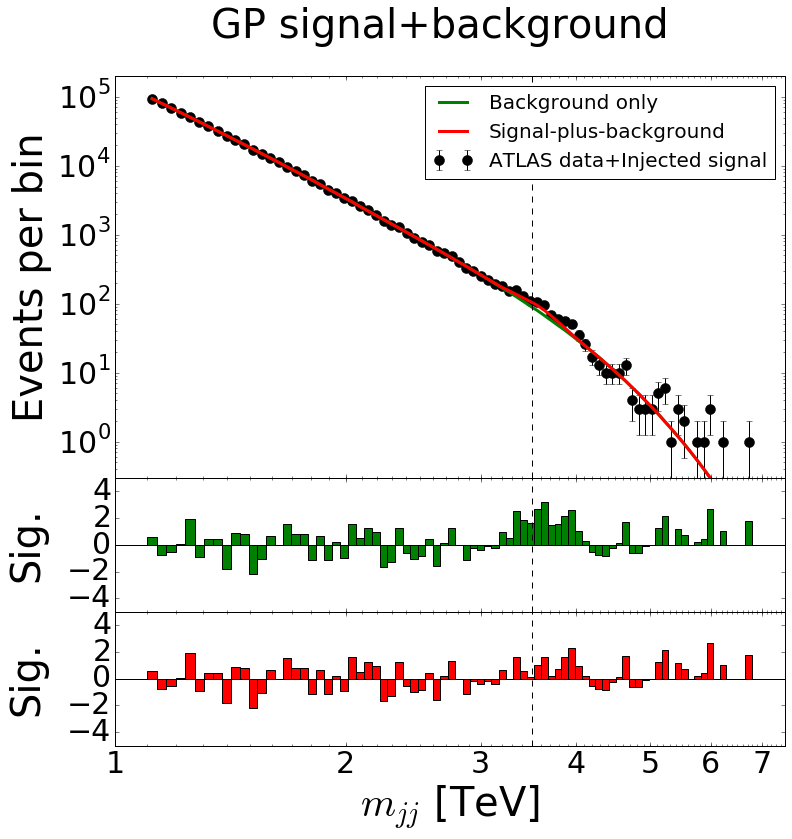

8000
background only time: 0.00298500061035
background + signal time: 0.00349283218384
chi2 bkg+signal mu=0 660.861073724
chi2 bkg+signal 596.673766483


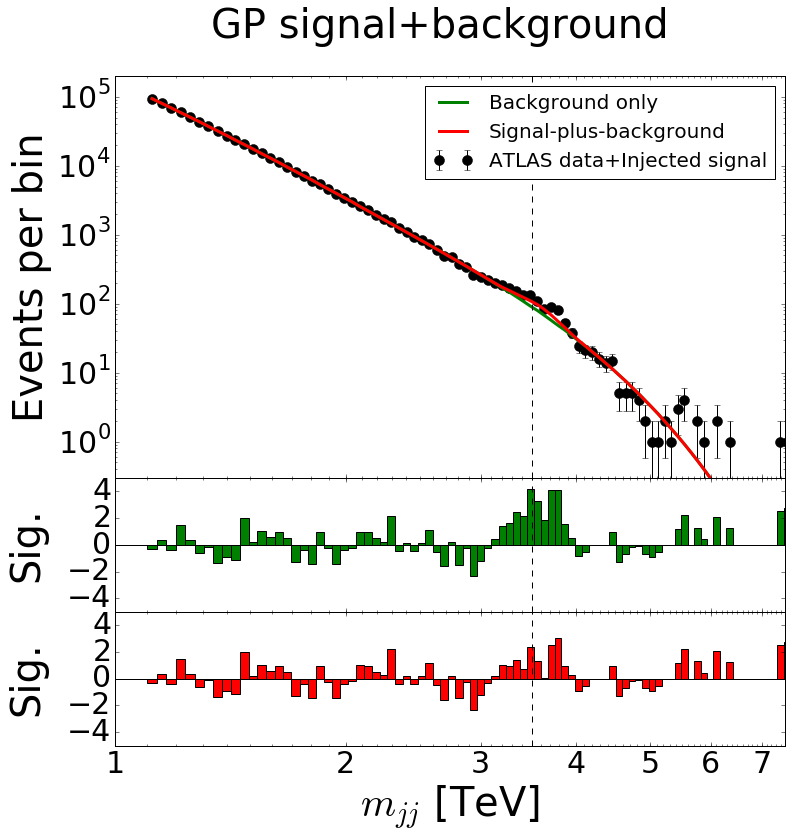

8500
background only time: 0.00288987159729
background + signal time: 0.00341796875
chi2 bkg+signal mu=0 676.718308472
chi2 bkg+signal 615.522708877


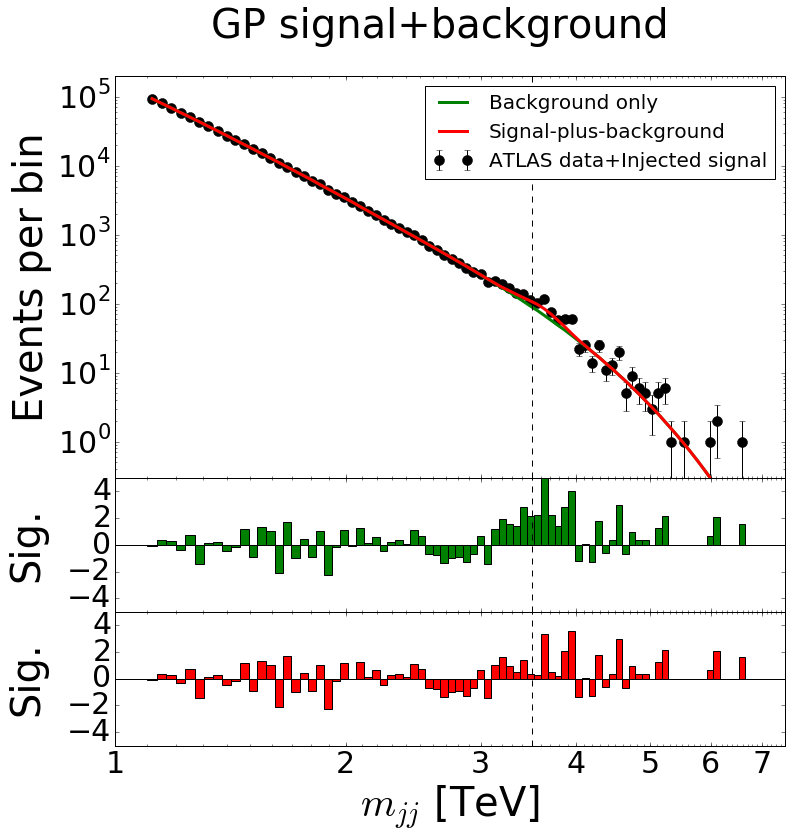

9000
background only time: 0.00287413597107
background + signal time: 0.00340604782104
chi2 bkg+signal mu=0 132.08410344
chi2 bkg+signal 107.806790088


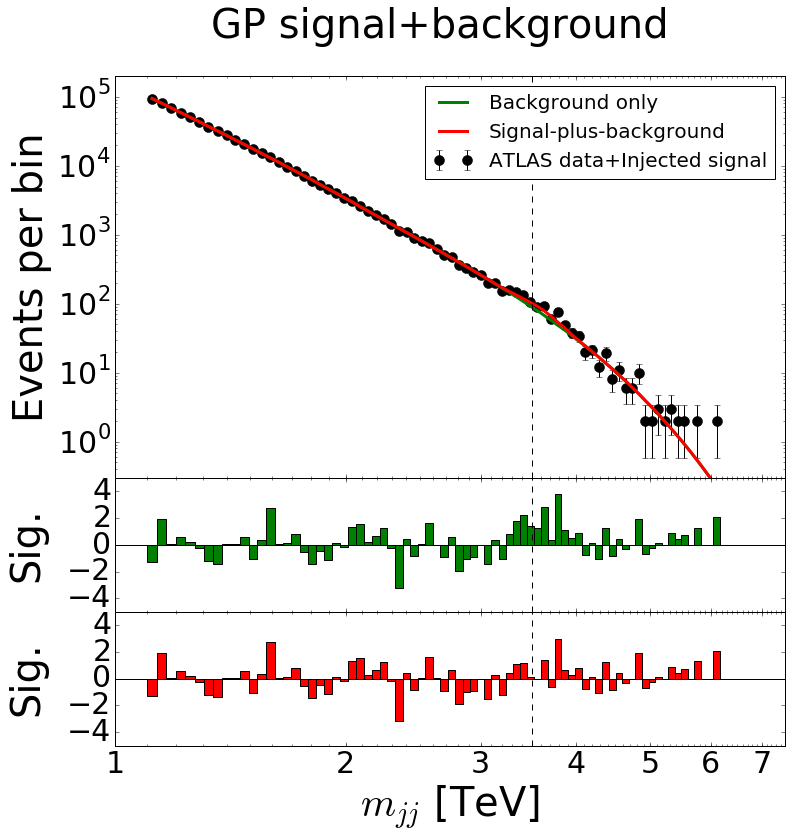

9500
background only time: 0.00288796424866
background + signal time: 0.00344610214233
chi2 bkg+signal mu=0 312.933598203
chi2 bkg+signal 282.60441092


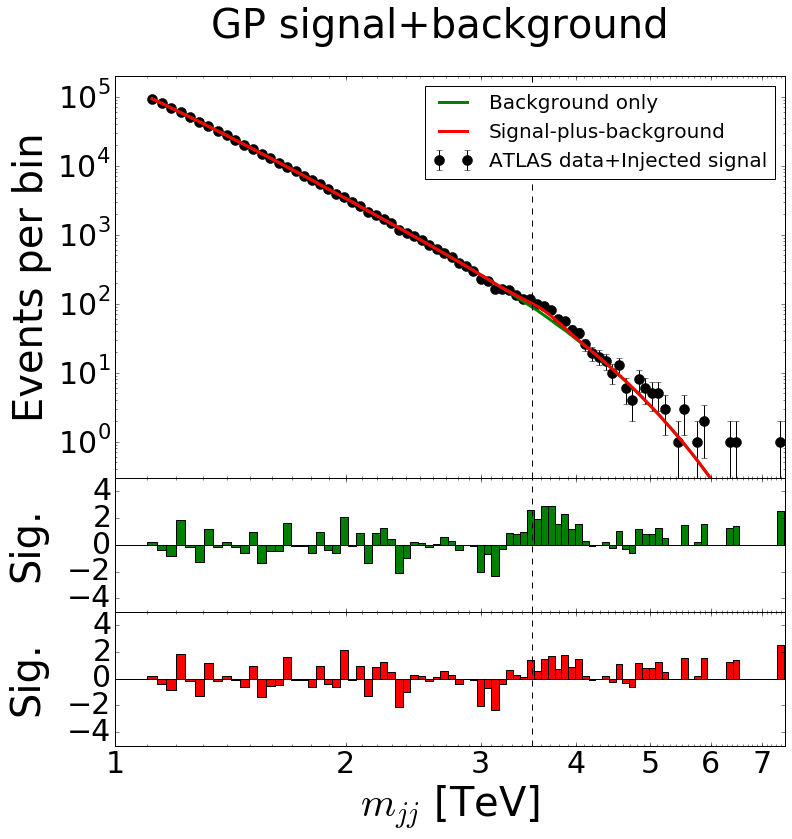

took 0.034186270833hours


In [46]:
sigToys = np.load("newoutputs/signalToys_3500.npy")
sigToysO = np.load("newoutputs/signalToysO_3500.npy")
toyList = np.load("newoutputs/toyList_3500.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_largeL={}


    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_largeL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy + signalTemplate

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 30, 3500, 250, 250
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            LLlistGP_largeL[m].append(-2*(gpLLH-gpLLHSig))

    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(300, 3500, 250)
0
background only time: 0.0041618347168
background + signal time: 0.00427007675171
chi2 bkg+signal mu=0 376.337318907
chi2 bkg+signal 336.957400867


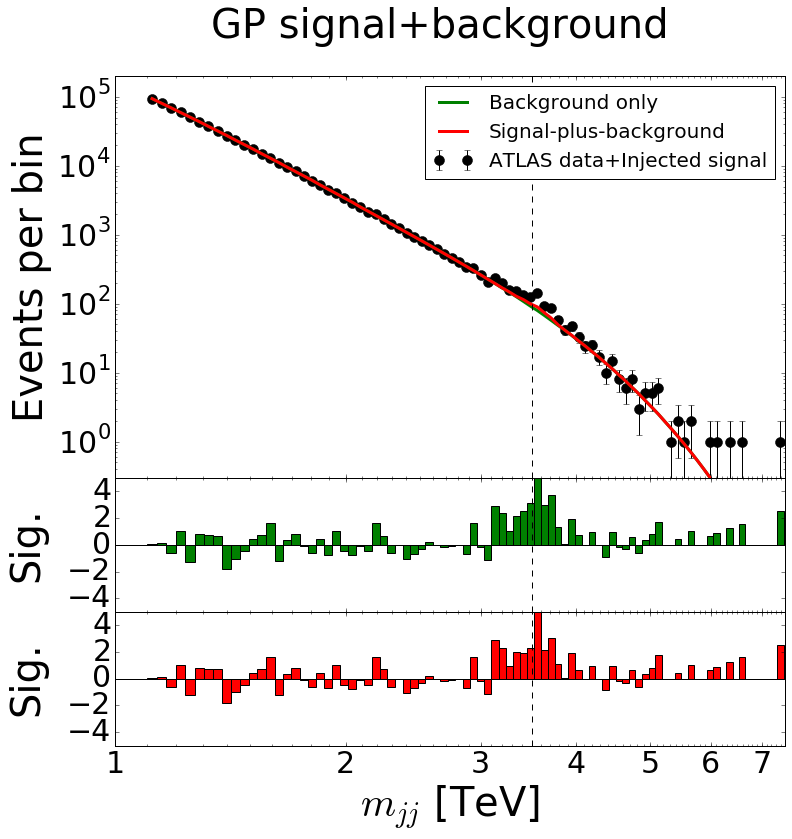

500
background only time: 0.00372695922852
background + signal time: 0.00356721878052
chi2 bkg+signal mu=0 974.31056734
chi2 bkg+signal 953.386734806


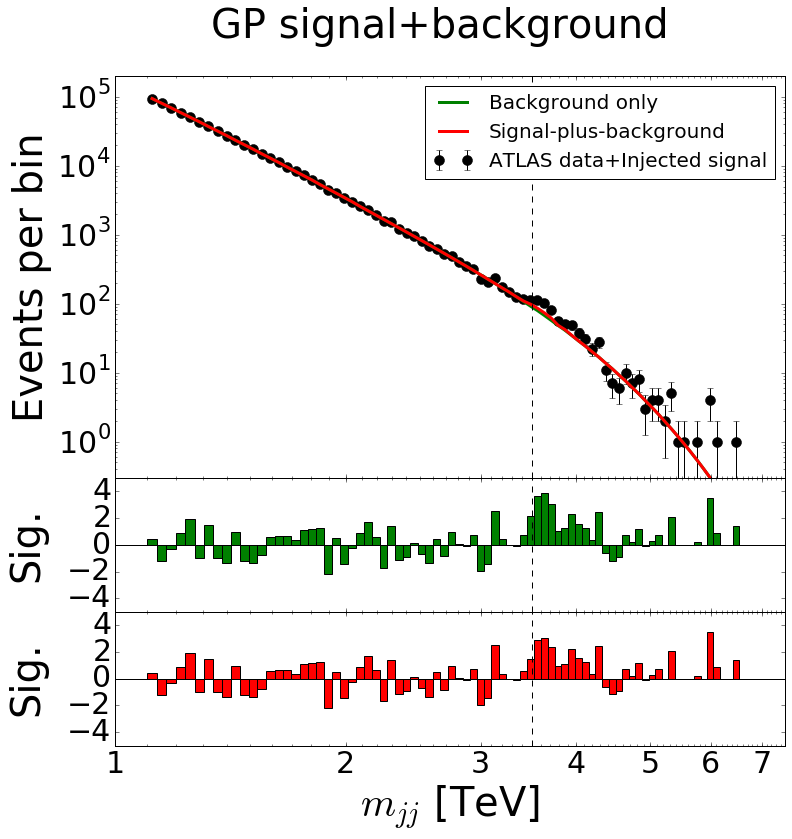

1000
background only time: 0.00285482406616
background + signal time: 0.00341320037842
chi2 bkg+signal mu=0 284.788800421
chi2 bkg+signal 254.412839656


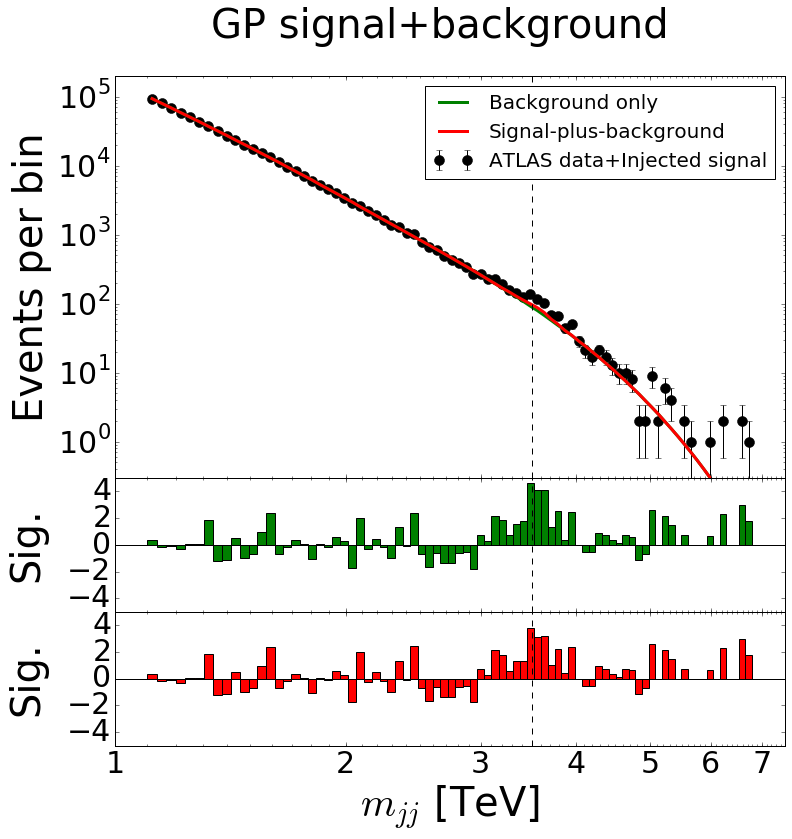

1500
background only time: 0.0029571056366
background + signal time: 0.00349497795105
chi2 bkg+signal mu=0 227.455349328
chi2 bkg+signal 202.906883053


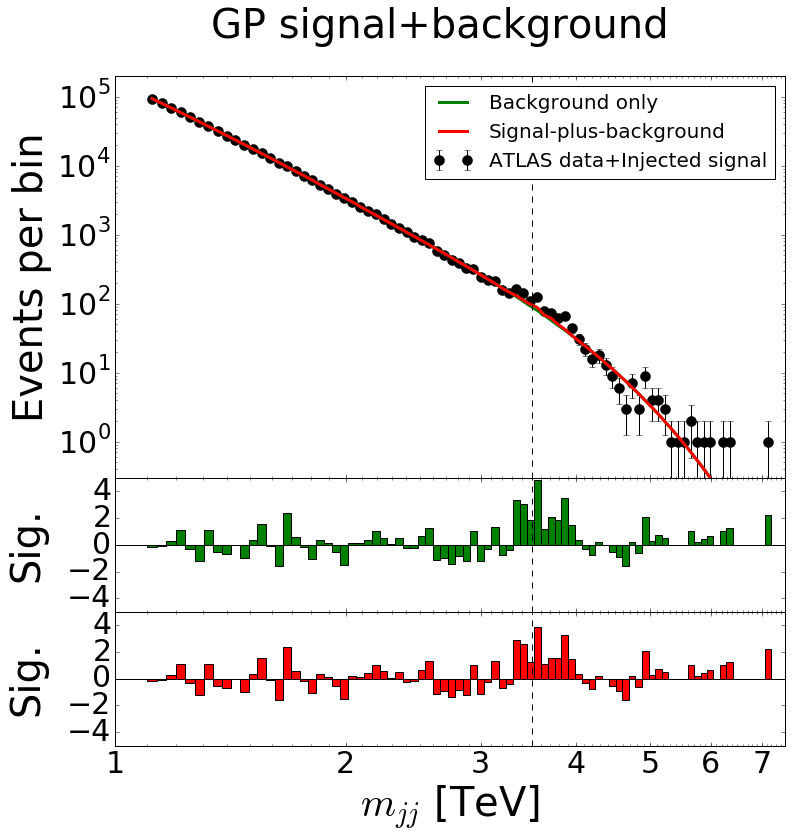

2000
background only time: 0.00409007072449
background + signal time: 0.00529789924622
chi2 bkg+signal mu=0 205.981121016
chi2 bkg+signal 183.765691509


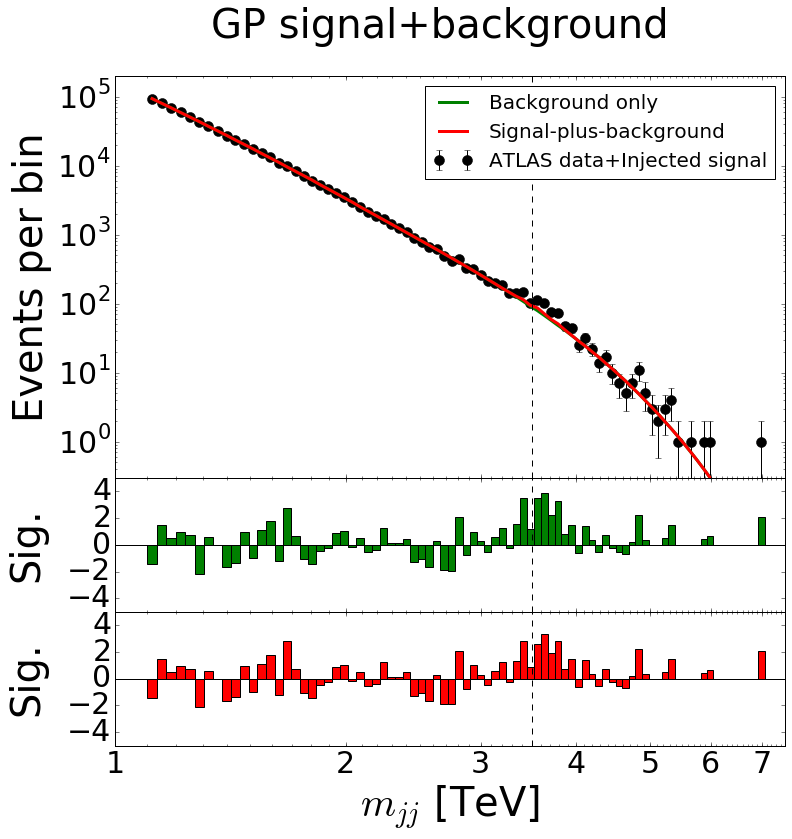

2500
background only time: 0.00297403335571
background + signal time: 0.0034019947052
chi2 bkg+signal mu=0 148.510121059
chi2 bkg+signal 129.299982376


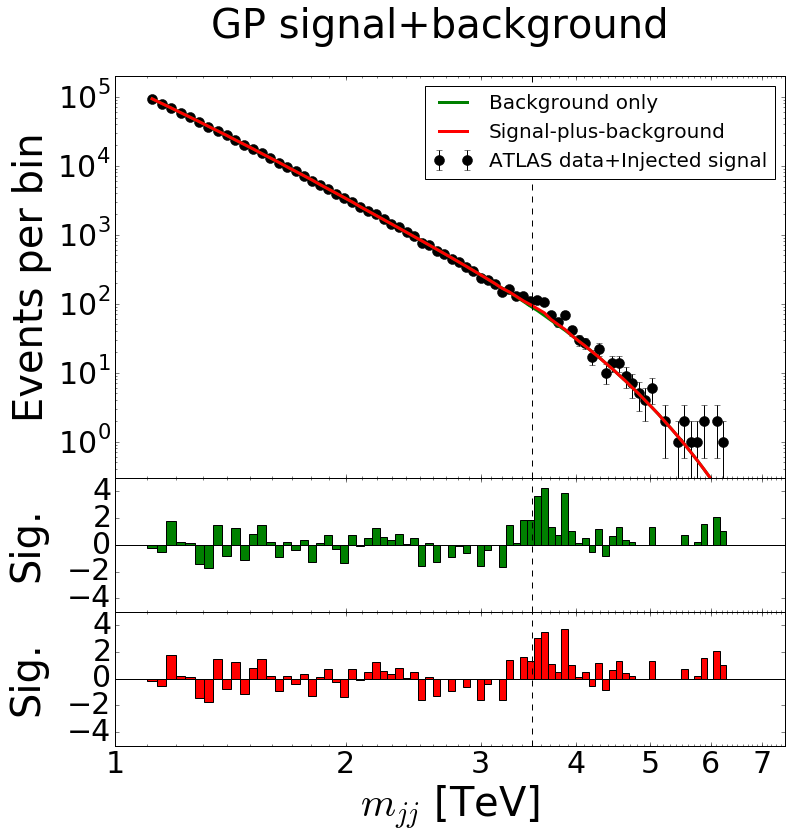

3000
background only time: 0.00294208526611
background + signal time: 0.00345802307129
chi2 bkg+signal mu=0 183.89988983
chi2 bkg+signal 164.373640075


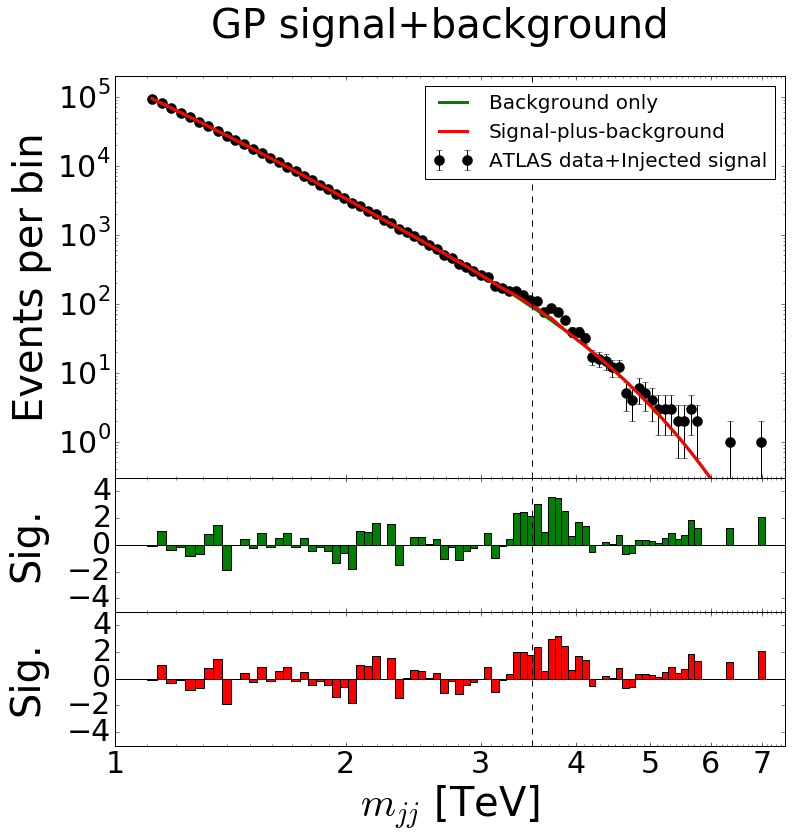

3500
background only time: 0.00290703773499
background + signal time: 0.00339722633362
chi2 bkg+signal mu=0 222.428483129
chi2 bkg+signal 204.079481668


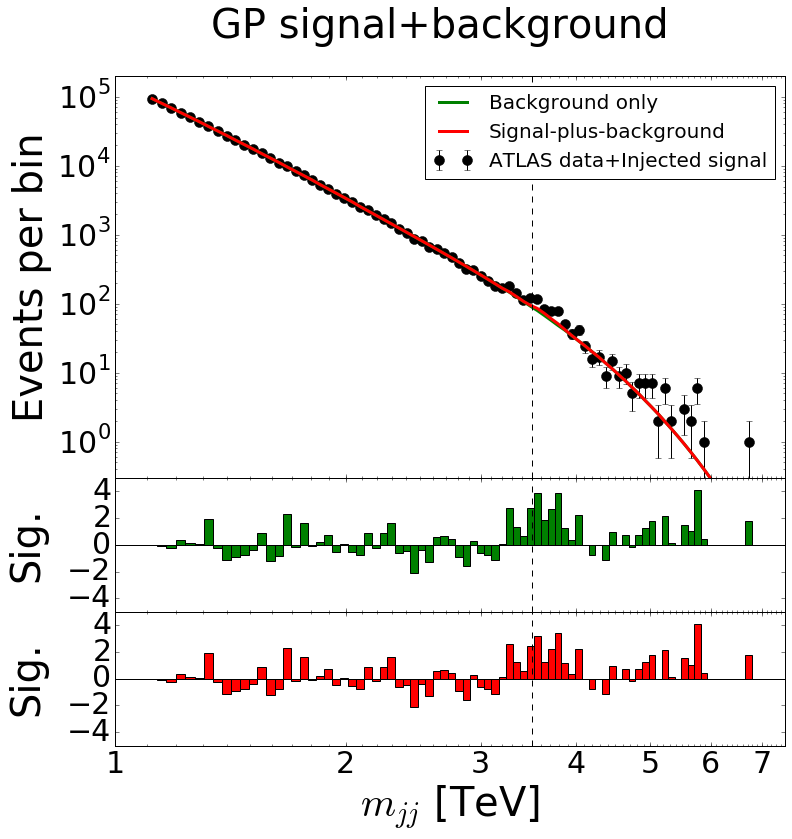

4000
background only time: 0.00314903259277
background + signal time: 0.00346899032593
chi2 bkg+signal mu=0 180.034421072
chi2 bkg+signal 157.280718674


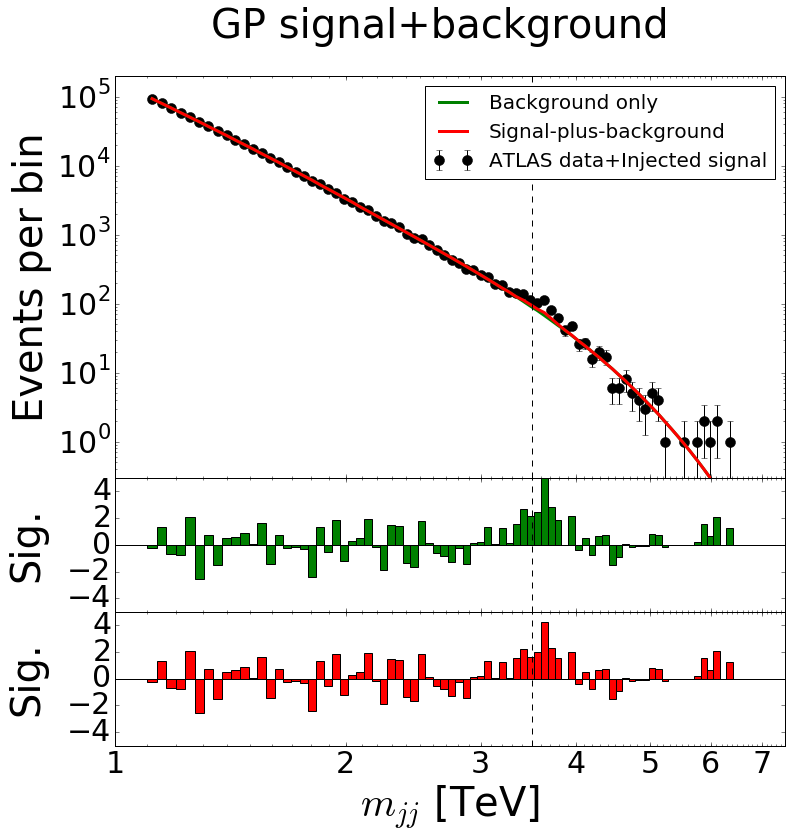

4500
background only time: 0.0029718875885
background + signal time: 0.00346207618713
chi2 bkg+signal mu=0 257.768849797
chi2 bkg+signal 232.710784135


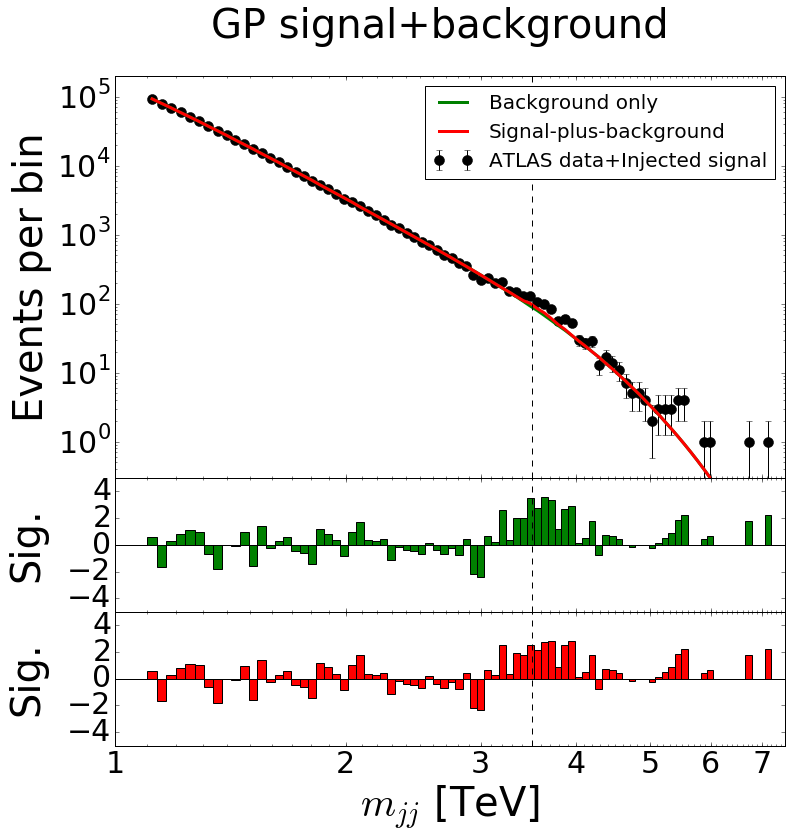

5000
background only time: 0.00362110137939
background + signal time: 0.00357294082642
chi2 bkg+signal mu=0 202.632214082
chi2 bkg+signal 180.101974697


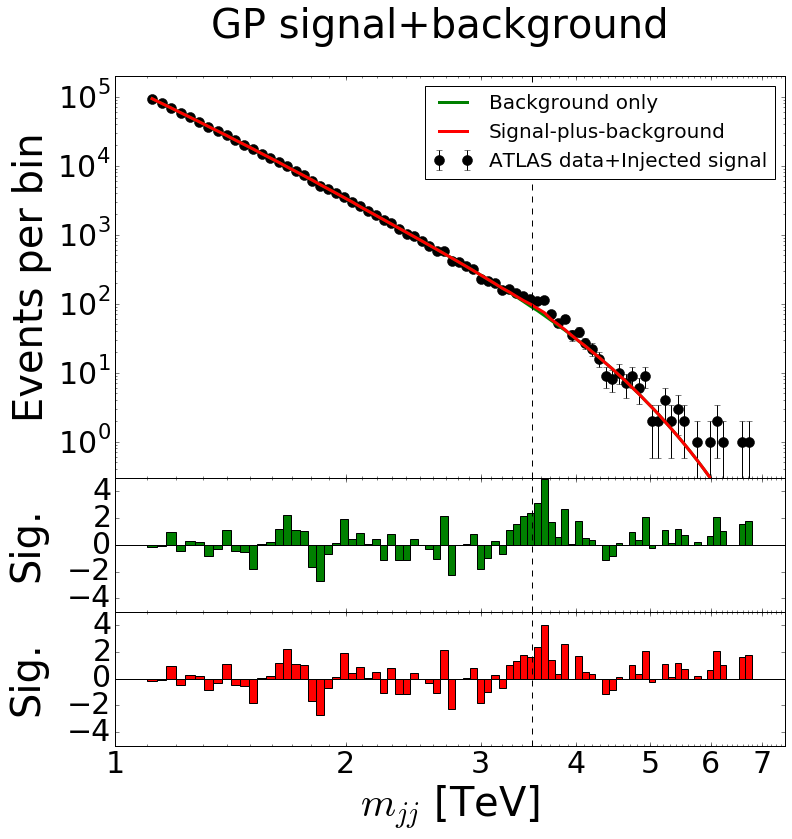

5500
background only time: 0.00316500663757
background + signal time: 0.00363302230835
chi2 bkg+signal mu=0 320.034901783
chi2 bkg+signal 291.378700046


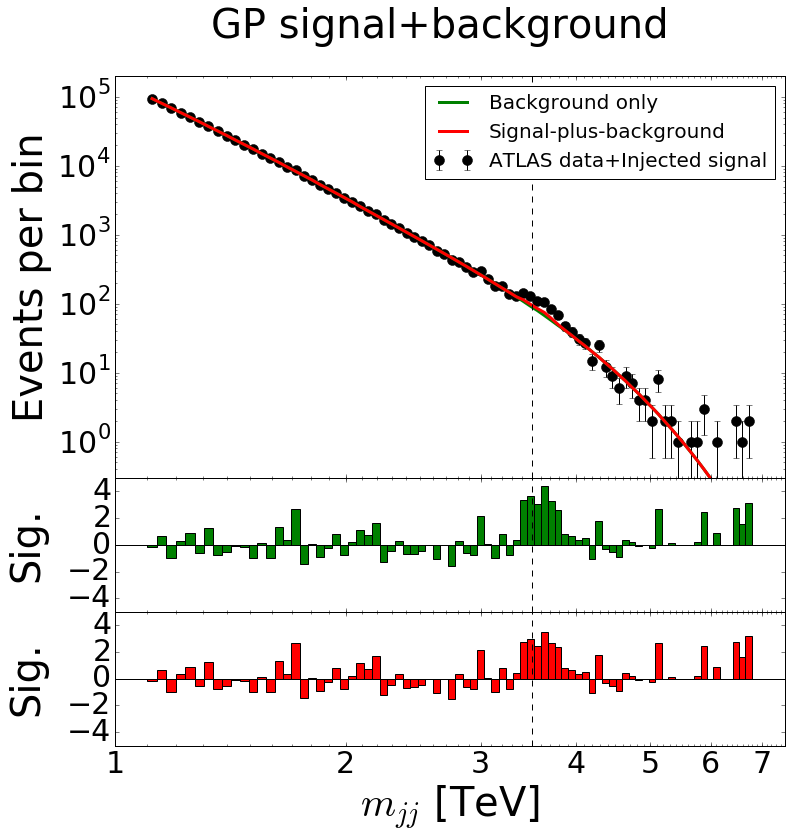

6000
background only time: 0.00292801856995
background + signal time: 0.00342607498169
chi2 bkg+signal mu=0 513.400950982
chi2 bkg+signal 486.191870849


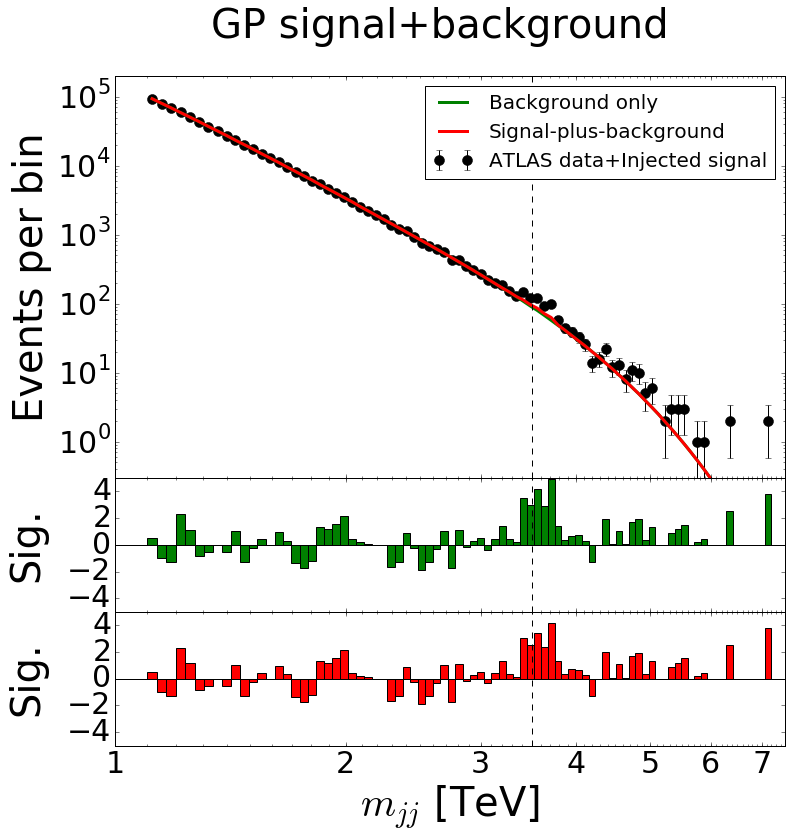

6500
background only time: 0.00293397903442
background + signal time: 0.00338888168335
chi2 bkg+signal mu=0 239.415588997
chi2 bkg+signal 218.017236133


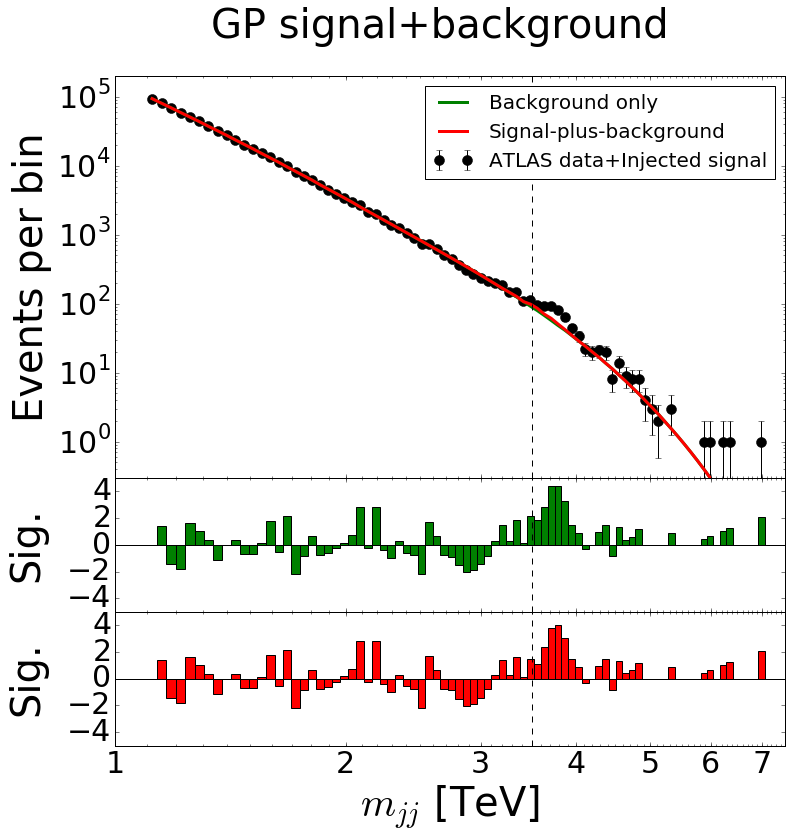

7000
background only time: 0.00293898582458
background + signal time: 0.00341796875
chi2 bkg+signal mu=0 125.619770342
chi2 bkg+signal 108.509447272


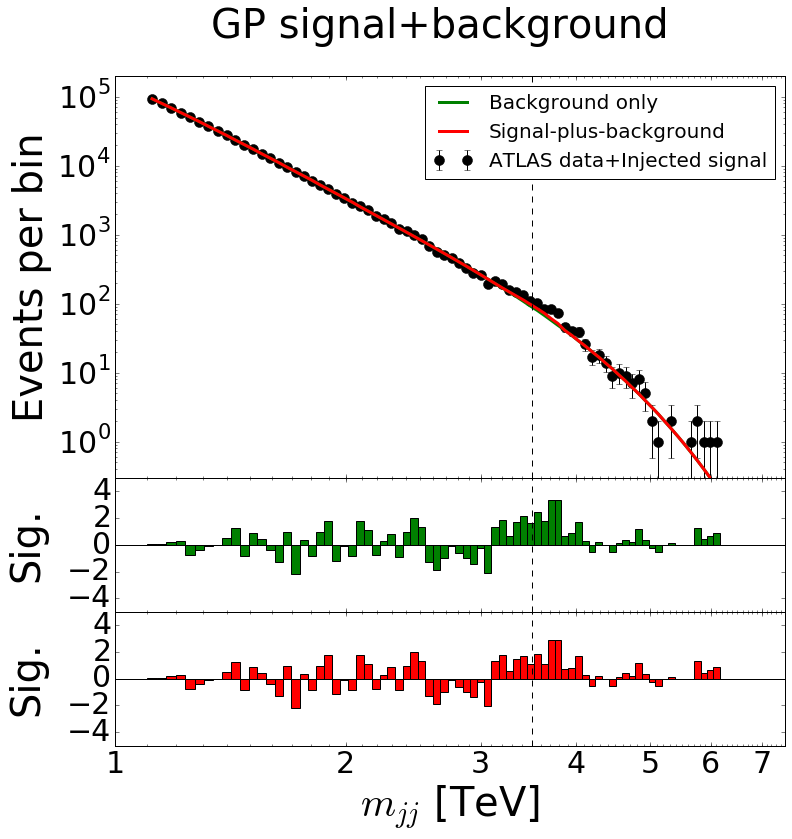

7500
background only time: 0.00295901298523
background + signal time: 0.00345301628113
chi2 bkg+signal mu=0 176.618580389
chi2 bkg+signal 160.846504064


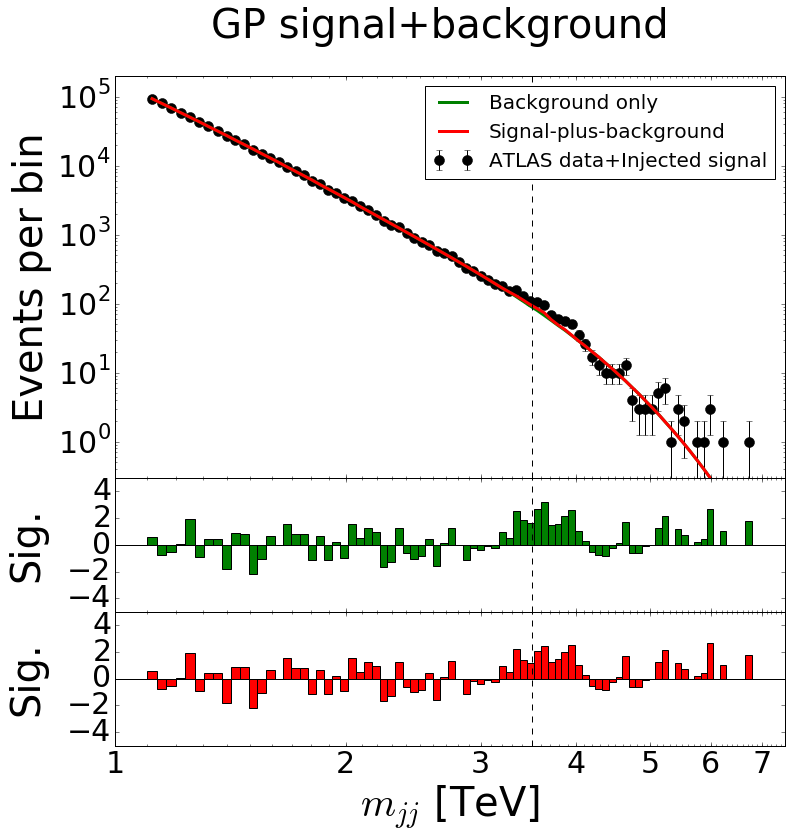

8000
background only time: 0.00295901298523
background + signal time: 0.00347805023193
chi2 bkg+signal mu=0 660.861073724
chi2 bkg+signal 631.432157324


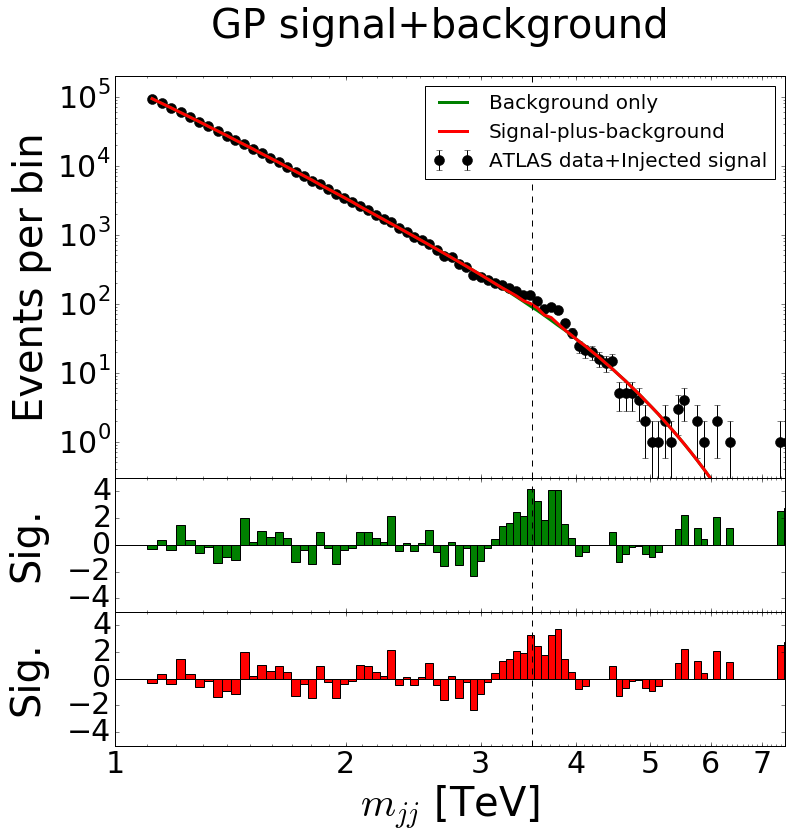

8500
background only time: 0.00447702407837
background + signal time: 0.00450491905212
chi2 bkg+signal mu=0 676.718308472
chi2 bkg+signal 648.416353332


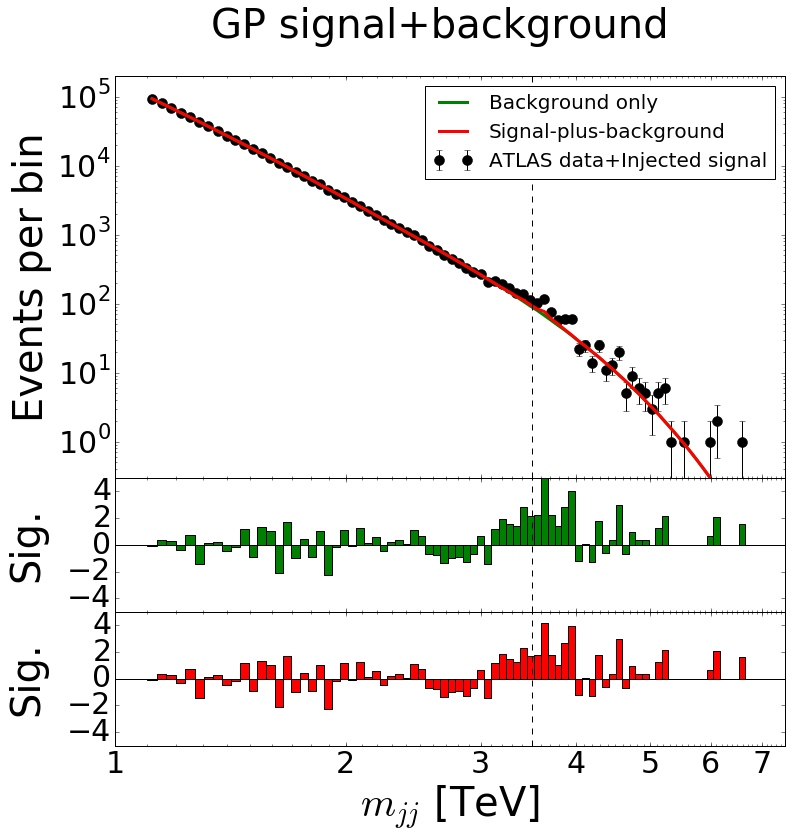

9000
background only time: 0.00290989875793
background + signal time: 0.00341105461121
chi2 bkg+signal mu=0 132.08410344
chi2 bkg+signal 119.916861344


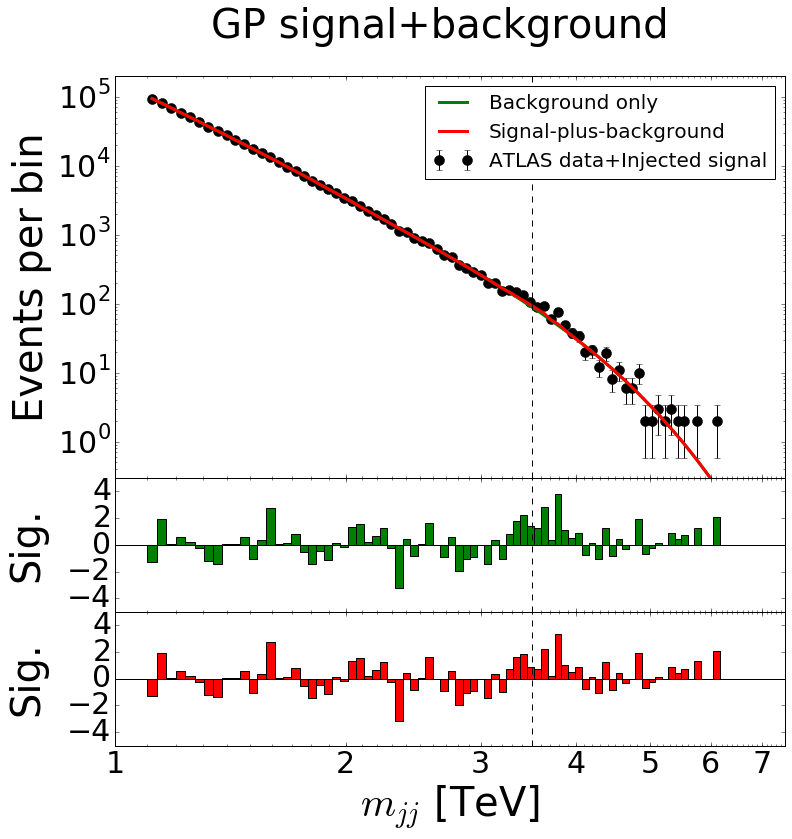

9500
background only time: 0.00466418266296
background + signal time: 0.00500297546387
chi2 bkg+signal mu=0 312.933598203
chi2 bkg+signal 299.666081997


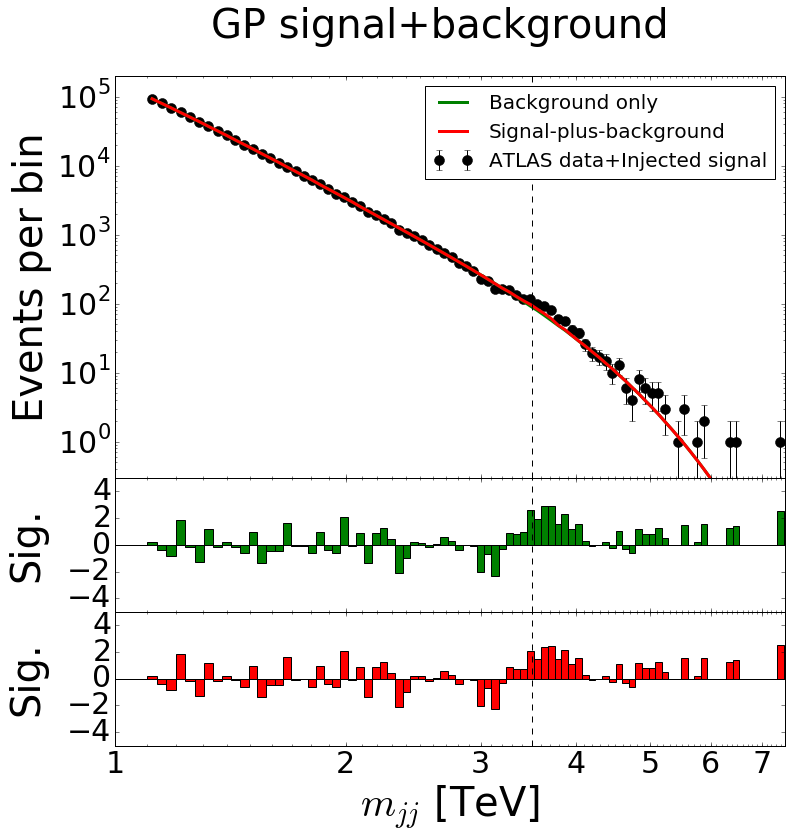

took 0.0340171994766hours


In [47]:
#sigToys = np.load("newoutputs/signalToys_3500.npy")
#sigToysO = np.load("newoutputs/signalToysO_3500.npy")
#toyList = np.load("newoutputs/toyList_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_smallL={}

    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_smallL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy + signalTemplate

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 30, 3500, 250, 25
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            LLlistGP_smallL[m].append(-2*(gpLLH-gpLLHSig))


    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

george LL% < 0:  0.0
george LL% < 0:  0.0
nc  [ 5.96669128]
nc  [ 20.08036801]


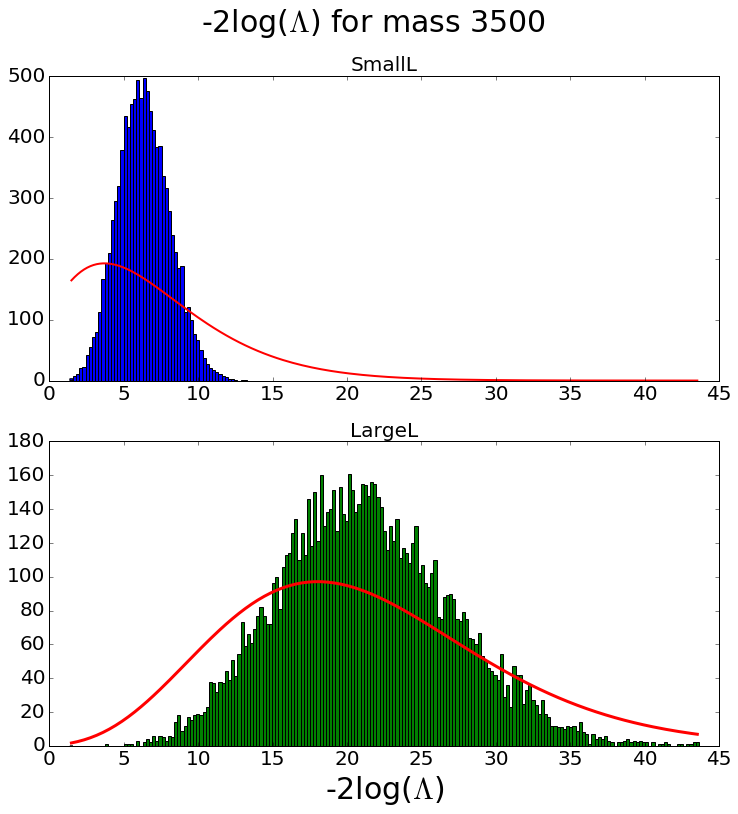

In [50]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

for m in msignals:
    gp_smallL = [s for s in LLlistGP_smallL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_smallL = round(100.*sum(i < 0 for i in gp_smallL)/len(gp_smallL),2)
    print "george LL% < 0: ", gp_neg_frac_smallL
    
    gp_smallL = [s for s in gp_smallL if s > 0]
    
    gp_largeL = [s for s in LLlistGP_largeL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_largeL = round(100.*sum(i < 0 for i in gp_largeL)/len(gp_largeL),2)
    print "george LL% < 0: ", gp_neg_frac_largeL
    
    gp_largeL = [s for s in gp_largeL if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="SmallL", label2 = "LargeL")
    
